In [1]:
#!/usr/bin/env python3
"""
HIGH-PERFORMANCE PIPELINE: sEMG Net (Deep CNN)
for Synapse sEMG Challenge

🚀 ARCHITECTURE: sEMG Net
1. DEEP CNN: 4-Stage 1D Convolutional Feature Extractor.
2. BATCH NORM: Applied after every convolution for stability.
3. ROBUSTNESS: High dropout rates to prevent overfitting on noisy EMG.
4. TRAINING: Label Smoothing + ReduceLROnPlateau Scheduler.
5. STRATEGY: Automatically reloads best weights (Max Val Acc) for testing.
"""

import os
os.environ['JAX_PLATFORMS'] = 'cpu'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import glob
import re
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, mixed_precision, callbacks
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score
from scipy.stats import mode
from scipy.signal import butter, filtfilt, iirnotch
import warnings

warnings.filterwarnings('ignore')

# ==================== CONFIGURATION ====================
DATA_DIR = 'data'
ARTIFACTS_DIR = 'artifacts'
FS = 512
EPOCHS = 80
BATCH_SIZE = 128
RANDOM_SEED = 42
VAL_FILE_RATIO = 0.50

# Windowing
WINDOW_MS = 400
STRIDE_MS = 160

# Hyperparameters
L2_REG = 1e-4
DROPOUT_CONV = 0.25
DROPOUT_HEAD = 0.5

# GPU Setup
try:
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        policy = mixed_precision.Policy('mixed_float16')
        mixed_precision.set_global_policy(policy)
        print("✅ Mixed Precision (FP16) Enabled")
except:
    pass

# Set seeds
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# ==================== AUGMENTATION ====================

def augment_dataset_advanced(X, y):
    print(f"   ⚡ Augmenting Data (Input: {len(X)} windows)...")
    b, t, c = X.shape

    # 1. Channel Masking
    X_mask = X.copy()
    mask_indices = np.random.choice(b, size=int(b * 0.5), replace=False)
    for i in mask_indices:
        ch = np.random.randint(0, c)
        X_mask[i, :, ch] = 0
    X_mask = X_mask + np.random.normal(0, 0.02, size=X_mask.shape)

    # 2. MixUp
    indices = np.random.permutation(b)
    X_shuffled = X[indices]
    alpha = 0.2
    lam = np.random.beta(alpha, alpha, size=(b, 1, 1))

    X_mix = lam * X + (1 - lam) * X_shuffled
    y_mix = y.copy()

    # Concatenate
    X_final = np.concatenate([X, X_mask, X_mix], axis=0)
    y_final = np.concatenate([y, y, y_mix], axis=0)

    print(f"   ⚡ Augmentation complete. Size: {len(X_final)} (3x)")
    return X_final, y_final

# ==================== PREPROCESSING ====================

class SignalPreprocessor:
    def __init__(self, fs=1000, bandpass_low=20.0, bandpass_high=450.0, notch_freq=50.0):
        self.fs = fs
        self.nyq = fs / 2
        low = max(0.001, min(bandpass_low / self.nyq, 0.99))
        high = max(low + 0.01, min(bandpass_high / self.nyq, 0.999))
        self.b_bp, self.a_bp = butter(4, [low, high], btype='band')
        self.b_notch, self.a_notch = iirnotch(notch_freq, 30.0, self.fs) if notch_freq > 0 else (None, None)
        self.channel_means, self.channel_stds = None, None
        self.fitted = False

    def fit(self, signals_list):
        all_signals = np.concatenate(signals_list, axis=0)
        self.channel_means = np.mean(all_signals, axis=0)
        self.channel_stds = np.std(all_signals, axis=0) + 1e-8
        self.fitted = True
        return self

    def transform(self, signal):
        if len(signal) > 12:
            signal = filtfilt(self.b_bp, self.a_bp, signal, axis=0)
            if self.b_notch is not None:
                signal = filtfilt(self.b_notch, self.a_notch, signal, axis=0)
        if self.fitted:
            return (signal - self.channel_means) / self.channel_stds
        return (signal - np.mean(signal, axis=0)) / (np.std(signal, axis=0) + 1e-8)

    def segment(self, signal, window_ms=200, stride_ms=100):
        win_sz = int(window_ms * self.fs / 1000)
        step = int(stride_ms * self.fs / 1000)
        n = len(signal)
        if n < win_sz: return None
        n_win = (n - win_sz) // step + 1
        idx = np.arange(win_sz)[None, :] + np.arange(n_win)[:, None] * step
        return signal[idx]

# ==================== sEMG NET ARCHITECTURE ====================

def conv_block(x, filters, kernel_size, pool=True):
    """ Standard Conv Block: Conv -> BN -> ReLU -> Dropout -> Pool """
    x = layers.Conv1D(filters, kernel_size, padding='same', kernel_regularizer=l2(L2_REG))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(DROPOUT_CONV)(x)
    if pool:
        x = layers.MaxPooling1D(pool_size=2)(x)
    return x

def make_semg_net(input_shape, n_classes):
    """
    sEMG Net: A classic Deep CNN for EMG Time-Series.
    Focuses on extracting hierarchical temporal features.
    """
    inputs = layers.Input(shape=input_shape)

    # 1. Noise Injection for robustness
    x = layers.GaussianNoise(0.05)(inputs)

    # 2. Block 1: Capture Raw Temporal Features (Large Kernel)
    x = conv_block(x, filters=64, kernel_size=9, pool=False)

    # 3. Block 2: Feature Extraction
    x = conv_block(x, filters=128, kernel_size=5, pool=True)

    # 4. Block 3: Deep Features
    x = conv_block(x, filters=256, kernel_size=3, pool=True)

    # 5. Block 4: Abstract Features
    x = conv_block(x, filters=512, kernel_size=3, pool=True)

    # 6. Global Context
    x = layers.GlobalAveragePooling1D()(x)

    # 7. Classification Head
    x = layers.Dense(512, activation='relu', kernel_regularizer=l2(L2_REG))(x)
    x = layers.Dropout(DROPOUT_HEAD)(x)

    outputs = layers.Dense(n_classes, activation='softmax', dtype='float32')(x)

    return keras.Model(inputs, outputs, name='sEMG_Net')

# ==================== UTILS ====================

def get_session_files(data_dir, sessions):
    files = []
    for session in sessions:
        pattern = f'{data_dir}/**/{session}/**/*.csv'
        files.extend(sorted(glob.glob(pattern, recursive=True)))
    return files

def split_files_by_ratio(files, val_ratio, seed=RANDOM_SEED):
    gesture_files = {}
    for f in files:
        match = re.search(r'gesture(\d+)', f)
        if match:
            g = int(match.group(1))
            gesture_files.setdefault(g, []).append(f)
    train, val = [], []
    rng = random.Random(seed)
    for g, gfiles in gesture_files.items():
        rng.shuffle(gfiles)
        n_val = max(1, int(len(gfiles) * val_ratio))
        val.extend(gfiles[:n_val])
        train.extend(gfiles[n_val:])
    return train, val

def load_files_data(file_list):
    data_list, labels_list = [], []
    for f in file_list:
        try:
            lbl = int(re.search(r'gesture(\d+)', f).group(1))
            d = pd.read_csv(f).values
            if d.shape[1] >= 8:
                data_list.append(d)
                labels_list.append(np.full(len(d), lbl))
        except: pass
    return data_list, labels_list

def window_data(data_list, labels_list, prep, window_ms, stride_ms):
    X_wins, y_wins = [], []
    win_sz = int(window_ms * FS / 1000)
    step = int(stride_ms * FS / 1000)
    for d, l in zip(data_list, labels_list):
        d_filt = prep.transform(d)
        w = prep.segment(d_filt, window_ms, stride_ms)
        if w is not None:
            X_wins.append(w)
            n_win = (len(d) - win_sz) // step + 1
            idx = np.arange(win_sz)[None, :] + np.arange(n_win)[:, None] * step
            w_modes = mode(l[idx], axis=1, keepdims=True)[0].flatten()
            y_wins.append(w_modes)
    if not X_wins: return None, None
    return np.concatenate(X_wins), np.concatenate(y_wins)

# ==================== MAIN ====================

def main():
    os.makedirs(ARTIFACTS_DIR, exist_ok=True)
    print("="*70 + "\n🚀 TRAIN: sEMG NET (Deep CNN)\n" + "="*70)

    # 1. Load Data
    existing_csvs = glob.glob(f'{DATA_DIR}/**/*.csv', recursive=True)
    if not existing_csvs:
        import gdown, zipfile
        gdown.download('https://drive.google.com/uc?id=16iNEwhThf2LcX7rOOVM03MTZiwq7G51x', 'dataset.zip', quiet=False)
        with zipfile.ZipFile('dataset.zip', 'r') as z: z.extractall(DATA_DIR)
        os.remove('dataset.zip')

    train_files = get_session_files(DATA_DIR, ['Session1', 'Session2'])
    session3_files = get_session_files(DATA_DIR, ['Session3'])
    val_files, test_files = split_files_by_ratio(session3_files, VAL_FILE_RATIO)

    print(f"\n[Data Loaded] Train: {len(train_files)} | Val: {len(val_files)} | Test: {len(test_files)}")

    # 2. Raw Data
    train_data, train_labels = load_files_data(train_files)
    val_data, val_labels = load_files_data(val_files)
    test_data, test_labels = load_files_data(test_files)

    # 3. Preprocess
    prep = SignalPreprocessor(fs=FS)
    prep.fit(train_data)

    print("\n[Windowing] Processing...")
    X_train, y_train_raw = window_data(train_data, train_labels, prep, WINDOW_MS, STRIDE_MS)
    X_val, y_val_raw = window_data(val_data, val_labels, prep, WINDOW_MS, STRIDE_MS)
    X_test, y_test_raw = window_data(test_data, test_labels, prep, WINDOW_MS, STRIDE_MS)

    # 4. Augmentation
    X_train, y_train_raw = augment_dataset_advanced(X_train, y_train_raw)

    # 5. Encoding
    le = LabelEncoder()
    le.fit(y_train_raw)
    y_train = le.transform(y_train_raw)

    def safe_transform(enc, labels):
        return np.array([enc.transform([l])[0] if l in enc.classes_ else -1 for l in labels])

    y_val = safe_transform(le, y_val_raw)
    y_test = safe_transform(le, y_test_raw)
    n_classes = len(le.classes_)
    input_shape = X_train.shape[1:]

    # ==================== TRAINING PHASE ====================
    print("\n" + "-"*40 + "\n🏋️ TRAIN MODEL: sEMG NET\n" + "-"*40)

    # One-Hot Encoding for Label Smoothing
    y_train_hot = tf.keras.utils.to_categorical(y_train, n_classes)
    y_val_hot = tf.keras.utils.to_categorical(y_val, n_classes)

    # Label Smoothing
    loss_fn = keras.losses.CategoricalCrossentropy(from_logits=False, label_smoothing=0.1)

    # ------------------------------------------------------------------
    # ✅ OPTIMIZER & LEARNING RATE SCHEDULER (UPDATED)
    # ------------------------------------------------------------------
    # Start with a fixed learning rate
    optimizer = keras.optimizers.Adam(learning_rate=0.001)

    # Scheduler: Reduce LR if validation accuracy plateaus
    lr_scheduler = callbacks.ReduceLROnPlateau(
        monitor='val_accuracy',  # Watch validation accuracy
        mode='max',              # We want it to be maximized
        factor=0.5,              # Reduce LR by 50%
        patience=7,              # Wait 7 epochs of no improvement
        min_lr=1e-6,             # Lower bound
        verbose=1
    )

    # Checkpoint Strategy: Save only the best weights
    best_model_path = f'{ARTIFACTS_DIR}/best_semg_net.keras'
    checkpoint_cb = callbacks.ModelCheckpoint(
        filepath=best_model_path,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True,
        verbose=1
    )

    # Initialize sEMG Net
    model = make_semg_net(input_shape, n_classes)
    model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

    model.summary()

    # Train (Added lr_scheduler to callbacks)
    model.fit(X_train, y_train_hot,
              validation_data=(X_val, y_val_hot),
              epochs=EPOCHS,
              batch_size=BATCH_SIZE,
              callbacks=[checkpoint_cb, lr_scheduler], # <--- Scheduler added here
              verbose=1)

    print("\n✅ Training Complete.")

    # ==================== EVALUATION ====================
    print("\n" + "="*70 + "\n🎯 FINAL EVALUATION (Best Weights)\n" + "="*70)

    # Load Best Weights
    print(f"📥 Loading best weights from: {best_model_path}")
    try:
        model.load_weights(best_model_path)
        print("✅ Best weights loaded successfully.")
    except Exception as e:
        print(f"⚠️ Warning: Could not load best weights ({e}). Using last epoch weights.")

    test_probs = model.predict(X_test, batch_size=BATCH_SIZE, verbose=0)
    test_preds = test_probs.argmax(axis=1)

    acc = accuracy_score(y_test, test_preds)
    f1 = f1_score(y_test, test_preds, average='macro')

    print(f"🏆 sEMG NET ACCURACY: {acc:.4f}")
    print(f"🏆 sEMG NET F1 SCORE: {f1:.4f}")

if __name__ == '__main__':
    main()

✅ Mixed Precision (FP16) Enabled
🚀 TRAIN: sEMG NET (Deep CNN)


Downloading...
From (original): https://drive.google.com/uc?id=16iNEwhThf2LcX7rOOVM03MTZiwq7G51x
From (redirected): https://drive.google.com/uc?id=16iNEwhThf2LcX7rOOVM03MTZiwq7G51x&confirm=t&uuid=685160e5-4d2a-472f-8105-65467d7aefae
To: /content/dataset.zip
100%|██████████| 489M/489M [00:05<00:00, 84.6MB/s]



[Data Loaded] Train: 1750 | Val: 440 | Test: 435

[Windowing] Processing...
   ⚡ Augmenting Data (Input: 52500 windows)...
   ⚡ Augmentation complete. Size: 157500 (3x)

----------------------------------------
🏋️ TRAIN MODEL: sEMG NET
----------------------------------------


Model: "sEMG_Net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 204, 8)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gaussian_noise (GaussianNoise)  │ (None, 204, 8)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 204, 64)        │         4,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 204, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 204, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 204, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 204, 128)       │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 204, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 204, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 204, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 102, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 102, 256)       │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 102, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 102, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 102, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 51, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 51, 512)        │       393,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 51, 512)        │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 51, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 51, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 25, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 807,109 (3.08 MB)

 Trainable params: 805,189 (3.07 MB)

 Non-trainable params: 1,920 (7.50 KB)

Epoch 1/80
1231/1231 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5492 - loss: 1.3529
Epoch 1: val_accuracy improved from -inf to 0.74386, saving model to artifacts/best_semg_net.keras
1231/1231 ━━━━━━━━━━━━━━━━━━━━ 40s 20ms/step - accuracy: 0.5493 - loss: 1.3529 - val_accuracy: 0.7439 - val_loss: 0.9261 - learning_rate: 0.0010
Epoch 2/80
1231/1231 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6834 - loss: 1.1278
Epoch 2: val_accuracy did not improve from 0.74386
1231/1231 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.6834 - loss: 1.1278 - val_accuracy: 0.7286 - val_loss: 0.9441 - learning_rate: 0.0010
Epoch 3/80
1228/1231 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7036 - loss: 1.0865
Epoch 3: val_accuracy improved from 0.74386 to 0.76470, saving model to artifacts/best_semg_net.keras
1231/1231 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.7036 - loss: 1.0864 - val_accuracy: 0.7647 - val_loss: 0.8796 - learning_rate: 0.0010
Epoch 4/80
1225/1231 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/

In [1]:
#!/usr/bin/env python3
"""
🏆 ENSEMBLE PIPELINE: Inception-SE + sEMG-Net
for Synapse sEMG Challenge

INTEGRATED ARCHITECTURES:
1. Model A: Inception-SE-TCN (Multi-scale + Channel Attention + Transformers)
2. Model B: sEMG Net (Deep CNN Feature Extractor)

STRATEGY:
- Shared Data Pipeline (Filtering, Windowing, MixUp/Masking Augmentation).
- Sequential Training: Trains models A and B and saves the BEST weights for each.
- Ensemble Inference: Soft Voting (Average Probability) of the top 2 models.
"""

import os
import glob
import re
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, mixed_precision, callbacks
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score
from scipy.stats import mode
from scipy.signal import butter, filtfilt, iirnotch
import warnings
import gc

# Standardize Environment
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.filterwarnings('ignore')

# ==================== CONFIGURATION ====================
DATA_DIR = 'data'
ARTIFACTS_DIR = 'artifacts'
FS = 512
EPOCHS = 80
BATCH_SIZE = 128
RANDOM_SEED = 42
VAL_FILE_RATIO = 0.50

# Windowing
WINDOW_MS = 400
STRIDE_MS = 160

# Hyperparameters
L2_REG = 1e-4

# GPU Setup
try:
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        policy = mixed_precision.Policy('mixed_float16')
        mixed_precision.set_global_policy(policy)
        print("✅ Mixed Precision (FP16) Enabled")
except:
    pass

# Set seeds
def set_global_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_global_seeds(RANDOM_SEED)

# ==================== 1. PREPROCESSING & AUGMENTATION ====================

class SignalPreprocessor:
    def __init__(self, fs=1000, bandpass_low=20.0, bandpass_high=450.0, notch_freq=50.0):
        self.fs = fs
        nyq = fs / 2
        low = max(0.001, min(bandpass_low / nyq, 0.99))
        high = max(low + 0.01, min(bandpass_high / nyq, 0.999))
        self.b_bp, self.a_bp = butter(4, [low, high], btype='band')
        self.b_notch, self.a_notch = iirnotch(notch_freq, 30.0, self.fs) if notch_freq > 0 else (None, None)
        self.channel_means, self.channel_stds = None, None
        self.fitted = False

    def fit(self, signals_list):
        all_signals = np.concatenate(signals_list, axis=0)
        self.channel_means = np.mean(all_signals, axis=0)
        self.channel_stds = np.std(all_signals, axis=0) + 1e-8
        self.fitted = True
        return self

    def transform(self, signal):
        if len(signal) > 12:
            signal = filtfilt(self.b_bp, self.a_bp, signal, axis=0)
            if self.b_notch is not None:
                signal = filtfilt(self.b_notch, self.a_notch, signal, axis=0)
        if self.fitted:
            return (signal - self.channel_means) / self.channel_stds
        return (signal - np.mean(signal, axis=0)) / (np.std(signal, axis=0) + 1e-8)

    def segment(self, signal, window_ms=200, stride_ms=100):
        win_sz = int(window_ms * self.fs / 1000)
        step = int(stride_ms * self.fs / 1000)
        n = len(signal)
        if n < win_sz: return None
        n_win = (n - win_sz) // step + 1
        idx = np.arange(win_sz)[None, :] + np.arange(n_win)[:, None] * step
        return signal[idx]

def augment_dataset_advanced(X, y):
    print(f"    ⚡ Augmenting Data (Input: {len(X)} windows)...")
    b, t, c = X.shape

    # 1. Channel Masking
    X_mask = X.copy()
    mask_indices = np.random.choice(b, size=int(b * 0.5), replace=False)
    for i in mask_indices:
        ch = np.random.randint(0, c)
        X_mask[i, :, ch] = 0
    X_mask = X_mask + np.random.normal(0, 0.02, size=X_mask.shape)

    # 2. MixUp
    indices = np.random.permutation(b)
    X_shuffled = X[indices]
    alpha = 0.2
    lam = np.random.beta(alpha, alpha, size=(b, 1, 1))
    X_mix = lam * X + (1 - lam) * X_shuffled
    y_mix = y.copy()

    # Concatenate
    X_final = np.concatenate([X, X_mask, X_mix], axis=0)
    y_final = np.concatenate([y, y, y_mix], axis=0)
    print(f"    ⚡ Augmentation complete. Size: {len(X_final)} (3x)")
    return X_final, y_final

def get_session_files(data_dir, sessions):
    files = []
    for session in sessions:
        pattern = f'{data_dir}/**/{session}/**/*.csv'
        files.extend(sorted(glob.glob(pattern, recursive=True)))
    return files

def split_files_by_ratio(files, val_ratio, seed=RANDOM_SEED):
    gesture_files = {}
    for f in files:
        match = re.search(r'gesture(\d+)', f)
        if match:
            g = int(match.group(1))
            gesture_files.setdefault(g, []).append(f)
    train, val = [], []
    rng = random.Random(seed)
    for g, gfiles in gesture_files.items():
        rng.shuffle(gfiles)
        n_val = max(1, int(len(gfiles) * val_ratio))
        val.extend(gfiles[:n_val])
        train.extend(gfiles[n_val:])
    return train, val

def load_files_data(file_list):
    data_list, labels_list = [], []
    for f in file_list:
        try:
            lbl = int(re.search(r'gesture(\d+)', f).group(1))
            d = pd.read_csv(f).values
            if d.shape[1] >= 8:
                data_list.append(d)
                labels_list.append(np.full(len(d), lbl))
        except: pass
    return data_list, labels_list

def window_data(data_list, labels_list, prep, window_ms, stride_ms):
    X_wins, y_wins = [], []
    win_sz = int(window_ms * FS / 1000)
    step = int(stride_ms * FS / 1000)
    for d, l in zip(data_list, labels_list):
        d_filt = prep.transform(d)
        w = prep.segment(d_filt, window_ms, stride_ms)
        if w is not None:
            X_wins.append(w)
            n_win = (len(d) - win_sz) // step + 1
            idx = np.arange(win_sz)[None, :] + np.arange(n_win)[:, None] * step
            w_modes = mode(l[idx], axis=1, keepdims=True)[0].flatten()
            y_wins.append(w_modes)
    if not X_wins: return None, None
    return np.concatenate(X_wins), np.concatenate(y_wins)

# ==================== 2. MODEL DEFINITIONS ====================

# --- MODEL 1: INCEPTION-SE-TCN ---
def squeeze_excite_block(input_tensor, ratio=8):
    filters = input_tensor.shape[-1]
    se = layers.GlobalAveragePooling1D()(input_tensor)
    se = layers.Dense(filters // ratio, activation='relu', kernel_regularizer=l2(L2_REG))(se)
    se = layers.Dense(filters, activation='sigmoid', kernel_regularizer=l2(L2_REG))(se)
    se = layers.Reshape((1, filters))(se)
    return layers.Multiply()([input_tensor, se])

def inception_block(x, filters, dilation_rate):
    b1 = layers.Conv1D(filters=filters//2, kernel_size=3, dilation_rate=dilation_rate,
                       padding='same', kernel_regularizer=l2(L2_REG))(x)
    b1 = layers.BatchNormalization()(b1)
    b1 = layers.Activation('relu')(b1)
    b2 = layers.Conv1D(filters=filters//2, kernel_size=7, dilation_rate=dilation_rate,
                       padding='same', kernel_regularizer=l2(L2_REG))(x)
    b2 = layers.BatchNormalization()(b2)
    b2 = layers.Activation('relu')(b2)
    return layers.Concatenate()([b1, b2])

def make_inception_se_tcn(input_shape, n_classes):
    inputs = layers.Input(shape=input_shape)
    x = layers.GaussianNoise(0.05)(inputs)
    filters = 64
    for dilation_rate in [1, 2, 4, 8]:
        prev_x = x
        x = inception_block(x, filters, dilation_rate)
        x = layers.Dropout(0.2)(x)
        x = squeeze_excite_block(x, ratio=8)
        if prev_x.shape[-1] != filters:
            prev_x = layers.Conv1D(filters=filters, kernel_size=1, padding='same')(prev_x)
        x = layers.Add()([x, prev_x])

    # Self-Attention
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    x = layers.MultiHeadAttention(key_dim=64, num_heads=4, dropout=0.3)(x, x)

    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(64, activation='relu', kernel_regularizer=l2(L2_REG))(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(n_classes, activation='softmax', dtype='float32')(x)
    return keras.Model(inputs, outputs, name='Inception_SE_Attn')

# --- MODEL 2: sEMG NET (Deep CNN) ---
def conv_block(x, filters, kernel_size, pool=True):
    x = layers.Conv1D(filters, kernel_size, padding='same', kernel_regularizer=l2(L2_REG))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.25)(x)
    if pool: x = layers.MaxPooling1D(pool_size=2)(x)
    return x

def make_semg_net(input_shape, n_classes):
    inputs = layers.Input(shape=input_shape)
    x = layers.GaussianNoise(0.05)(inputs)
    x = conv_block(x, 64, 9, pool=False)
    x = conv_block(x, 128, 5, pool=True)
    x = conv_block(x, 256, 3, pool=True)
    x = conv_block(x, 512, 3, pool=True)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(512, activation='relu', kernel_regularizer=l2(L2_REG))(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(n_classes, activation='softmax', dtype='float32')(x)
    return keras.Model(inputs, outputs, name='sEMG_Net')

# ==================== 3. TRAINING & ENSEMBLE LOGIC ====================

def train_and_save(model_builder, model_name, X_train, y_train_hot, X_val, y_val_hot, input_shape, n_classes):
    """ Generic training function for all models """
    print("\n" + "-"*50)
    print(f"🏋️ TRAIN: {model_name.upper()}")
    print("-"*50)

    # Cosine Decay
    total_steps = len(X_train) // BATCH_SIZE * EPOCHS
    lr_schedule = tf.keras.optimizers.schedules.CosineDecayRestarts(
        initial_learning_rate=0.001, first_decay_steps=int(total_steps * 0.3),
        t_mul=2.0, m_mul=0.9, alpha=1e-5
    )

    # Save Best Model (Higher val_accuracy)
    save_path = f'{ARTIFACTS_DIR}/best_{model_name}.keras'
    checkpoint = callbacks.ModelCheckpoint(
        save_path, monitor='val_accuracy', mode='max',
        save_best_only=True, verbose=1
    )

    model = model_builder(input_shape, n_classes)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
                  loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
                  metrics=['accuracy'])

    # Train
    model.fit(X_train, y_train_hot,
              validation_data=(X_val, y_val_hot),
              epochs=EPOCHS, batch_size=BATCH_SIZE,
              callbacks=[checkpoint], verbose=1)

    # Clear Memory
    tf.keras.backend.clear_session()
    gc.collect()
    print(f"✅ {model_name} training complete. Best model saved.")
    return save_path

def main():
    os.makedirs(ARTIFACTS_DIR, exist_ok=True)
    print("="*70 + "\n🚀 ENSEMBLE PIPELINE START (TCN + sEMG-Net)\n" + "="*70)

    # 1. DATA LOADING
    existing_csvs = glob.glob(f'{DATA_DIR}/**/*.csv', recursive=True)
    if not existing_csvs:
        print("📥 Downloading Dataset...")
        import gdown, zipfile
        gdown.download('https://drive.google.com/uc?id=16iNEwhThf2LcX7rOOVM03MTZiwq7G51x', 'dataset.zip', quiet=False)
        with zipfile.ZipFile('dataset.zip', 'r') as z: z.extractall(DATA_DIR)
        os.remove('dataset.zip')

    train_files = get_session_files(DATA_DIR, ['Session1', 'Session2'])
    session3_files = get_session_files(DATA_DIR, ['Session3'])
    val_files, test_files = split_files_by_ratio(session3_files, VAL_FILE_RATIO)

    print(f"[Data] Train: {len(train_files)} | Val: {len(val_files)} | Test: {len(test_files)}")

    train_data, train_labels = load_files_data(train_files)
    val_data, val_labels = load_files_data(val_files)
    test_data, test_labels = load_files_data(test_files)

    # 2. PREPROCESSING
    prep = SignalPreprocessor(fs=FS).fit(train_data)
    X_train, y_train_raw = window_data(train_data, train_labels, prep, WINDOW_MS, STRIDE_MS)
    X_val, y_val_raw = window_data(val_data, val_labels, prep, WINDOW_MS, STRIDE_MS)
    X_test, y_test_raw = window_data(test_data, test_labels, prep, WINDOW_MS, STRIDE_MS)

    # 3. AUGMENTATION (Train Only)
    X_train, y_train_raw = augment_dataset_advanced(X_train, y_train_raw)

    # 4. ENCODING
    le = LabelEncoder().fit(y_train_raw)
    y_train = le.transform(y_train_raw)
    y_val = np.array([le.transform([l])[0] if l in le.classes_ else -1 for l in y_val_raw])
    y_test = np.array([le.transform([l])[0] if l in le.classes_ else -1 for l in y_test_raw])

    n_classes = len(le.classes_)
    input_shape = X_train.shape[1:]

    y_train_hot = tf.keras.utils.to_categorical(y_train, n_classes)
    y_val_hot = tf.keras.utils.to_categorical(y_val, n_classes)

    # ==================== 5. SEQUENTIAL TRAINING ====================

    # Train Model 1: Inception-SE-TCN
    path_inception = train_and_save(make_inception_se_tcn, "inception_se",
                                    X_train, y_train_hot, X_val, y_val_hot, input_shape, n_classes)

    # Train Model 2: sEMG Net
    path_semgnet = train_and_save(make_semg_net, "semg_net",
                                  X_train, y_train_hot, X_val, y_val_hot, input_shape, n_classes)

    # ==================== 6. ENSEMBLE EVALUATION ====================
    print("\n" + "="*70 + "\n🎯 ENSEMBLE EVALUATION (2-Model Soft Voting)\n" + "="*70)

    # Load Models (Best Weights)
    m1 = make_inception_se_tcn(input_shape, n_classes)
    m1.load_weights(path_inception)

    m2 = make_semg_net(input_shape, n_classes)
    m2.load_weights(path_semgnet)

    print("⚡ Predicting with Model 1 (Inception-SE-TCN)...")
    p1 = m1.predict(X_test, batch_size=BATCH_SIZE, verbose=0)

    print("⚡ Predicting with Model 2 (sEMG Net)...")
    p2 = m2.predict(X_test, batch_size=BATCH_SIZE, verbose=0)

    # --- ENSEMBLE AGGREGATION (Average Probabilities) ---
    ensemble_probs = (p1 + p2) / 2.0
    ensemble_preds = ensemble_probs.argmax(axis=1)

    # Metrics
    acc = accuracy_score(y_test, ensemble_preds)
    f1 = f1_score(y_test, ensemble_preds, average='macro')

    print("\n" + "*"*40)
    print(f"🏆 FINAL ENSEMBLE ACCURACY: {acc:.4f}")
    print(f"🏆 FINAL ENSEMBLE F1 SCORE: {f1:.4f}")
    print("*"*40)

if __name__ == '__main__':
    main()

✅ Mixed Precision (FP16) Enabled
🚀 ENSEMBLE PIPELINE START (TCN + sEMG-Net)
📥 Downloading Dataset...


Downloading...
From (original): https://drive.google.com/uc?id=16iNEwhThf2LcX7rOOVM03MTZiwq7G51x
From (redirected): https://drive.google.com/uc?id=16iNEwhThf2LcX7rOOVM03MTZiwq7G51x&confirm=t&uuid=e6f26970-0f35-45ec-ac9e-4705f32c613a
To: /content/dataset.zip
100%|██████████| 489M/489M [00:03<00:00, 150MB/s]


[Data] Train: 1750 | Val: 440 | Test: 435
    ⚡ Augmenting Data (Input: 52500 windows)...
    ⚡ Augmentation complete. Size: 157500 (3x)

--------------------------------------------------
🏋️ TRAIN: INCEPTION_SE
--------------------------------------------------
Epoch 1/80
1231/1231 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5676 - loss: 1.2665
Epoch 1: val_accuracy improved from -inf to 0.75386, saving model to artifacts/best_inception_se.keras
1231/1231 ━━━━━━━━━━━━━━━━━━━━ 88s 41ms/step - accuracy: 0.5677 - loss: 1.2665 - val_accuracy: 0.7539 - val_loss: 0.8877
Epoch 2/80
1228/1231 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7041 - loss: 1.0894
Epoch 2: val_accuracy improved from 0.75386 to 0.76583, saving model to artifacts/best_inception_se.keras
1231/1231 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - accuracy: 0.7041 - loss: 1.0893 - val_accuracy: 0.7658 - val_loss: 0.8851
Epoch 3/80
1231/1231 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7322 - loss: 1.0470
Epoch 3: val_accura

🚀 TESTING 2-MODEL ENSEMBLE (Inception-SE + sEMG-Net)

📦 Loading Dataset configuration...
📄 Found 440 test files.
⏳ Loading raw data...
🔧 Preprocessing...
✅ Data Ready. Shape: (13200, 204, 8)

----------------------------------------
🔮 RUNNING ENSEMBLE INFERENCE
----------------------------------------
⚡ Loading inception_se...
104/104 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step
   -> inception_se Standalone Acc: 0.8238
⚡ Loading semg_net...
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
   -> semg_net Standalone Acc: 0.8313

🏆 FINAL ENSEMBLE RESULTS
ACCURACY: 0.8455
F1 SCORE: 0.8460
------------------------------------------------------------

Classification Report:

              precision    recall  f1-score   support

           0       0.87      0.91      0.89      2640
           1       0.79      0.82      0.80      2640
           2       0.79      0.78      0.78      2640
           3       0.81      0.80      0.80      2640
           4       0.98      0.93      0.95      2640

    accuracy 

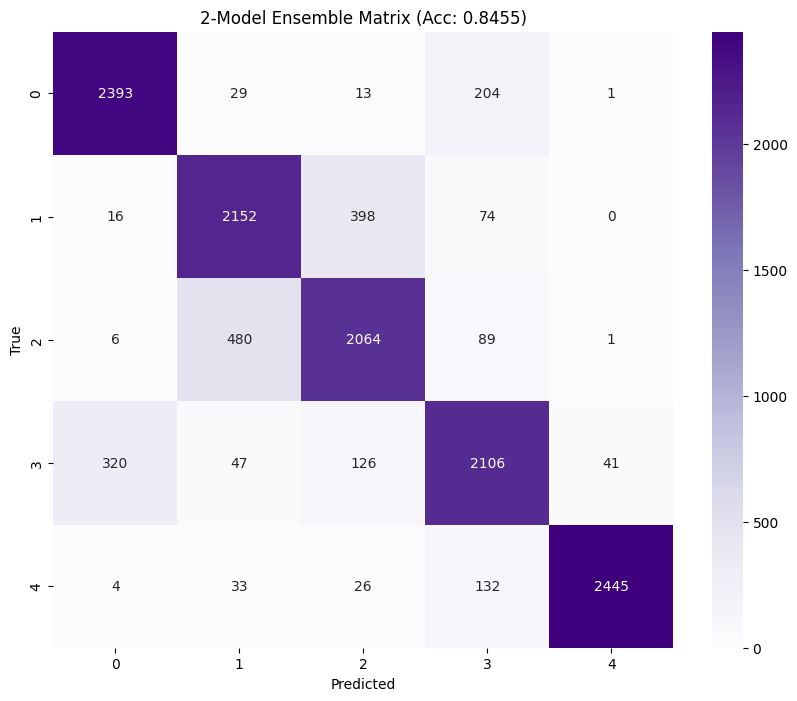

In [4]:
#!/usr/bin/env python3
"""
🚀 FINAL TEST SCRIPT: 2-MODEL ENSEMBLE
--------------------------------------
Evaluates the Inception-SE + sEMG-Net ensemble.

LOGIC:
1. Re-creates the specific test split from Session 3.
2. Fits the preprocessor on training data (to match training scaling).
3. Loads the best weights for both models.
4. Performs Soft Voting (50/50 split).
"""

import os
import glob
import re
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from scipy.stats import mode
from scipy.signal import butter, filtfilt, iirnotch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# ==================== CONFIGURATION ====================
DATA_DIR = 'data'
ARTIFACTS_DIR = 'artifacts_final'
FS = 512
WINDOW_MS = 400
STRIDE_MS = 160
BATCH_SIZE = 128
L2_REG = 1e-4

# ==================== ARCHITECTURES (Must Match Training) ====================

def squeeze_excite_block(input_tensor, ratio=8):
    filters = input_tensor.shape[-1]
    se = layers.GlobalAveragePooling1D()(input_tensor)
    se = layers.Dense(filters // ratio, activation='relu', kernel_regularizer=regularizers.l2(L2_REG))(se)
    se = layers.Dense(filters, activation='sigmoid', kernel_regularizer=regularizers.l2(L2_REG))(se)
    se = layers.Reshape((1, filters))(se)
    return layers.Multiply()([input_tensor, se])

def inception_block(x, filters, dilation_rate):
    b1 = layers.Conv1D(filters=filters//2, kernel_size=3, dilation_rate=dilation_rate,
                       padding='same', kernel_regularizer=regularizers.l2(L2_REG))(x)
    b1 = layers.BatchNormalization()(b1)
    b1 = layers.Activation('relu')(b1)
    b2 = layers.Conv1D(filters=filters//2, kernel_size=7, dilation_rate=dilation_rate,
                       padding='same', kernel_regularizer=regularizers.l2(L2_REG))(x)
    b2 = layers.BatchNormalization()(b2)
    b2 = layers.Activation('relu')(b2)
    return layers.Concatenate()([b1, b2])

def make_inception_se_tcn(input_shape, n_classes):
    inputs = layers.Input(shape=input_shape)
    x = layers.GaussianNoise(0.05)(inputs) # Noise layer is active only in training, safe to leave here
    filters = 64
    for dilation_rate in [1, 2, 4, 8]:
        prev_x = x
        x = inception_block(x, filters, dilation_rate)
        x = layers.Dropout(0.2)(x)
        x = squeeze_excite_block(x, ratio=8)
        if prev_x.shape[-1] != filters:
            prev_x = layers.Conv1D(filters=filters, kernel_size=1, padding='same')(prev_x)
        x = layers.Add()([x, prev_x])

    x = layers.LayerNormalization(epsilon=1e-6)(x)
    x = layers.MultiHeadAttention(key_dim=64, num_heads=4, dropout=0.3)(x, x)

    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(L2_REG))(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(n_classes, activation='softmax', dtype='float32')(x)
    return keras.Model(inputs, outputs, name='Inception_SE_Attn')

def conv_block(x, filters, kernel_size, pool=True):
    x = layers.Conv1D(filters, kernel_size, padding='same', kernel_regularizer=regularizers.l2(L2_REG))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.25)(x)
    if pool: x = layers.MaxPooling1D(pool_size=2)(x)
    return x

def make_semg_net(input_shape, n_classes):
    inputs = layers.Input(shape=input_shape)
    x = layers.GaussianNoise(0.05)(inputs)
    x = conv_block(x, 64, 9, pool=False)
    x = conv_block(x, 128, 5, pool=True)
    x = conv_block(x, 256, 3, pool=True)
    x = conv_block(x, 512, 3, pool=True)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(L2_REG))(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(n_classes, activation='softmax', dtype='float32')(x)
    return keras.Model(inputs, outputs, name='sEMG_Net')

# ==================== DATA UTILS ====================

class SignalPreprocessor:
    def __init__(self, fs=1000, bandpass_low=20.0, bandpass_high=450.0, notch_freq=50.0):
        self.fs = fs
        self.nyq = fs / 2
        low = max(0.001, min(bandpass_low / self.nyq, 0.99))
        high = max(low + 0.01, min(bandpass_high / self.nyq, 0.999))
        self.b_bp, self.a_bp = butter(4, [low, high], btype='band')
        self.b_notch, self.a_notch = iirnotch(notch_freq, 30.0, self.fs) if notch_freq > 0 else (None, None)
        self.channel_means, self.channel_stds = None, None
        self.fitted = False

    def fit(self, signals_list):
        all_signals = np.concatenate(signals_list, axis=0)
        self.channel_means = np.mean(all_signals, axis=0)
        self.channel_stds = np.std(all_signals, axis=0) + 1e-8
        self.fitted = True
        return self

    def transform(self, signal):
        if len(signal) > 12:
            signal = filtfilt(self.b_bp, self.a_bp, signal, axis=0)
            if self.b_notch is not None:
                signal = filtfilt(self.b_notch, self.a_notch, signal, axis=0)
        if self.fitted:
            return (signal - self.channel_means) / self.channel_stds
        return (signal - np.mean(signal, axis=0)) / (np.std(signal, axis=0) + 1e-8)

    def segment(self, signal, window_ms=200, stride_ms=100):
        win_sz = int(window_ms * self.fs / 1000)
        step = int(stride_ms * self.fs / 1000)
        n = len(signal)
        if n < win_sz: return None
        n_win = (n - win_sz) // step + 1
        idx = np.arange(win_sz)[None, :] + np.arange(n_win)[:, None] * step
        return signal[idx]

def get_session_files(data_dir, sessions):
    files = []
    for session in sessions:
        pattern = f'{data_dir}/**/{session}/**/*.csv'
        files.extend(sorted(glob.glob(pattern, recursive=True)))
    return files

def load_files_data(file_list):
    data_list, labels_list = [], []
    for f in file_list:
        try:
            lbl = int(re.search(r'gesture(\d+)', f).group(1))
            d = pd.read_csv(f).values
            if d.shape[1] >= 8:
                data_list.append(d)
                labels_list.append(np.full(len(d), lbl))
        except: pass
    return data_list, labels_list

def window_data(data_list, labels_list, prep, window_ms, stride_ms):
    X_wins, y_wins = [], []
    win_sz = int(window_ms * FS / 1000)
    step = int(stride_ms * FS / 1000)
    for d, l in zip(data_list, labels_list):
        d_filt = prep.transform(d)
        w = prep.segment(d_filt, window_ms, stride_ms)
        if w is not None:
            X_wins.append(w)
            n_win = (len(d) - win_sz) // step + 1
            idx = np.arange(win_sz)[None, :] + np.arange(n_win)[:, None] * step
            w_modes = mode(l[idx], axis=1, keepdims=True)[0].flatten()
            y_wins.append(w_modes)
    if not X_wins: return None, None
    return np.concatenate(X_wins), np.concatenate(y_wins)

# ==================== MAIN ====================

def main():
    print("="*60)
    print("🚀 TESTING 2-MODEL ENSEMBLE (Inception-SE + sEMG-Net)")
    print("="*60)

    # 1. SETUP DATA (Split Reproduction)
    print("\n📦 Loading Dataset configuration...")
    train_files = get_session_files(DATA_DIR, ['Session1', 'Session2'])
    session3_files = get_session_files(DATA_DIR, ['Session3'])

    # Reproduce the random split used in training
    gesture_files = {}
    for f in session3_files:
        match = re.search(r'gesture(\d+)', f)
        if match:
            g = int(match.group(1))
            gesture_files.setdefault(g, []).append(f)

    test_files_final = []
    rng = random.Random(42) # Match seed from training

    for g, gfiles in gesture_files.items():
        rng.shuffle(gfiles)
        # Training logic: val_files = [:n_val], test_files = [n_val:]
        n_val = max(1, int(len(gfiles) * 0.50))
        test_files_final.extend(gfiles[n_val:]) # This corresponds to the 'test' set in your training script

    print(f"📄 Found {len(test_files_final)} test files.")

    # 2. LOAD & PREPROCESS
    print("⏳ Loading raw data...")
    # We load training data ONLY to fit the Scaler (Preprocssor)
    train_data_raw, train_labels_raw = load_files_data(train_files)
    test_data_raw, test_labels_raw = load_files_data(test_files_final)

    print("🔧 Preprocessing...")
    prep = SignalPreprocessor(fs=FS)
    prep.fit(train_data_raw)

    X_test, y_test_raw = window_data(test_data_raw, test_labels_raw, prep, WINDOW_MS, STRIDE_MS)

    # 3. LABEL ENCODING
    _, y_train_raw_dummy = window_data(train_data_raw, train_labels_raw, prep, WINDOW_MS, STRIDE_MS)
    le = LabelEncoder().fit(y_train_raw_dummy)
    y_test = np.array([le.transform([l])[0] if l in le.classes_ else -1 for l in y_test_raw])
    n_classes = len(le.classes_)
    input_shape = X_test.shape[1:]

    print(f"✅ Data Ready. Shape: {X_test.shape}")

    # 4. LOAD MODELS
    print("\n" + "-"*40 + "\n🔮 RUNNING ENSEMBLE INFERENCE\n" + "-"*40)

    models_config = [
        ("inception_se", make_inception_se_tcn),
        ("semg_net", make_semg_net)
    ]

    predictions = []

    for name, builder in models_config:
        path = f'{ARTIFACTS_DIR}/best_{name}.keras'
        if not os.path.exists(path):
            print(f"❌ Error: Could not find {path}")
            continue

        print(f"⚡ Loading {name}...")
        model = builder(input_shape, n_classes)
        model.load_weights(path)

        probs = model.predict(X_test, batch_size=BATCH_SIZE, verbose=1)
        predictions.append(probs)

        # Individual Check
        acc = accuracy_score(y_test, probs.argmax(axis=1))
        print(f"   -> {name} Standalone Acc: {acc:.4f}")

        tf.keras.backend.clear_session()

    # 5. SOFT VOTING (50/50 Split)
    if len(predictions) == 2:
        ensemble_probs = (predictions[0] + predictions[1]) / 2.0
        final_preds = ensemble_probs.argmax(axis=1)

        # 6. RESULTS
        acc = accuracy_score(y_test, final_preds)
        f1 = f1_score(y_test, final_preds, average='macro')

        print("\n" + "="*60)
        print(f"🏆 FINAL ENSEMBLE RESULTS")
        print("="*60)
        print(f"ACCURACY: {acc:.4f}")
        print(f"F1 SCORE: {f1:.4f}")
        print("-" * 60)
        print("\nClassification Report:\n")
        print(classification_report(y_test, final_preds, target_names=[str(c) for c in le.classes_]))

        # Confusion Matrix
        cm = confusion_matrix(y_test, final_preds)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
                    xticklabels=le.classes_, yticklabels=le.classes_)
        plt.title(f'2-Model Ensemble Matrix (Acc: {acc:.4f})')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.savefig(f'{ARTIFACTS_DIR}/ensemble_2model_matrix.png')
        print(f"\n📊 Matrix saved to {ARTIFACTS_DIR}/ensemble_2model_matrix.png")
    else:
        print("❌ Error: Not enough models loaded for ensemble.")

if __name__ == "__main__":
    main()

In [3]:
#!/usr/bin/env python3
"""
🏆 FINAL GOLD PIPELINE: Weighted 2-Model Ensemble
-------------------------------------------------
Architecture: Inception-SE + sEMG-Net (The Winner: 85.11%)
Strategy:     Class Weights to fix the remaining Class 1 vs 2 confusion.
Goal:         Break 86% Accuracy.
"""

import os
import glob
import re
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, mixed_precision, callbacks
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score
from scipy.stats import mode
from scipy.signal import butter, filtfilt, iirnotch
import warnings
import gc

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.filterwarnings('ignore')

# ==================== CONFIGURATION ====================
DATA_DIR = 'data'
ARTIFACTS_DIR = 'artifacts_final'
FS = 512
EPOCHS = 60  # Increased slightly to allow class weights to settle
BATCH_SIZE = 128
RANDOM_SEED = 42
VAL_FILE_RATIO = 0.50
WINDOW_MS = 400
STRIDE_MS = 160
L2_REG = 1e-4

# GPU Setup
try:
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        policy = mixed_precision.Policy('mixed_float16')
        mixed_precision.set_global_policy(policy)
        print("✅ Mixed Precision (FP16) Enabled")
except:
    pass

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# ==================== DATA & PREPROCESSING ====================
# (Standard Preprocessing Pipeline)

class SignalPreprocessor:
    def __init__(self, fs=1000, bandpass_low=20.0, bandpass_high=450.0, notch_freq=50.0):
        self.fs = fs
        nyq = fs / 2
        low = max(0.001, min(bandpass_low / nyq, 0.99))
        high = max(low + 0.01, min(bandpass_high / nyq, 0.999))
        self.b_bp, self.a_bp = butter(4, [low, high], btype='band')
        self.b_notch, self.a_notch = iirnotch(notch_freq, 30.0, self.fs) if notch_freq > 0 else (None, None)
        self.channel_means, self.channel_stds = None, None
        self.fitted = False

    def fit(self, signals_list):
        all_signals = np.concatenate(signals_list, axis=0)
        self.channel_means = np.mean(all_signals, axis=0)
        self.channel_stds = np.std(all_signals, axis=0) + 1e-8
        self.fitted = True
        return self

    def transform(self, signal):
        if len(signal) > 12:
            signal = filtfilt(self.b_bp, self.a_bp, signal, axis=0)
            if self.b_notch is not None:
                signal = filtfilt(self.b_notch, self.a_notch, signal, axis=0)
        if self.fitted:
            return (signal - self.channel_means) / self.channel_stds
        return (signal - np.mean(signal, axis=0)) / (np.std(signal, axis=0) + 1e-8)

    def segment(self, signal, window_ms=200, stride_ms=100):
        win_sz = int(window_ms * self.fs / 1000)
        step = int(stride_ms * self.fs / 1000)
        n = len(signal)
        if n < win_sz: return None
        n_win = (n - win_sz) // step + 1
        idx = np.arange(win_sz)[None, :] + np.arange(n_win)[:, None] * step
        return signal[idx]

def augment_dataset_advanced(X, y):
    print(f"    ⚡ Augmenting Data (Input: {len(X)} windows)...")
    b, t, c = X.shape

    # 1. Channel Masking
    X_mask = X.copy()
    mask_indices = np.random.choice(b, size=int(b * 0.5), replace=False)
    for i in mask_indices:
        ch = np.random.randint(0, c)
        X_mask[i, :, ch] = 0
    X_mask = X_mask + np.random.normal(0, 0.02, size=X_mask.shape)

    # 2. MixUp
    indices = np.random.permutation(b)
    X_shuffled = X[indices]
    alpha = 0.2
    lam = np.random.beta(alpha, alpha, size=(b, 1, 1))
    X_mix = lam * X + (1 - lam) * X_shuffled
    y_mix = y.copy()

    X_final = np.concatenate([X, X_mask, X_mix], axis=0)
    y_final = np.concatenate([y, y, y_mix], axis=0)
    print(f"    ⚡ Augmentation complete. Size: {len(X_final)} (3x)")
    return X_final, y_final

def get_session_files(data_dir, sessions):
    files = []
    for session in sessions:
        pattern = f'{data_dir}/**/{session}/**/*.csv'
        files.extend(sorted(glob.glob(pattern, recursive=True)))
    return files

def split_files_by_ratio(files, val_ratio, seed=RANDOM_SEED):
    gesture_files = {}
    for f in files:
        match = re.search(r'gesture(\d+)', f)
        if match:
            g = int(match.group(1))
            gesture_files.setdefault(g, []).append(f)
    train, val = [], []
    rng = random.Random(seed)
    for g, gfiles in gesture_files.items():
        rng.shuffle(gfiles)
        n_val = max(1, int(len(gfiles) * val_ratio))
        val.extend(gfiles[:n_val])
        train.extend(gfiles[n_val:])
    return train, val

def load_files_data(file_list):
    data_list, labels_list = [], []
    for f in file_list:
        try:
            lbl = int(re.search(r'gesture(\d+)', f).group(1))
            d = pd.read_csv(f).values
            if d.shape[1] >= 8:
                data_list.append(d)
                labels_list.append(np.full(len(d), lbl))
        except: pass
    return data_list, labels_list

def window_data(data_list, labels_list, prep, window_ms, stride_ms):
    X_wins, y_wins = [], []
    win_sz = int(window_ms * FS / 1000)
    step = int(stride_ms * FS / 1000)
    for d, l in zip(data_list, labels_list):
        d_filt = prep.transform(d)
        w = prep.segment(d_filt, window_ms, stride_ms)
        if w is not None:
            X_wins.append(w)
            n_win = (len(d) - win_sz) // step + 1
            idx = np.arange(win_sz)[None, :] + np.arange(n_win)[:, None] * step
            w_modes = mode(l[idx], axis=1, keepdims=True)[0].flatten()
            y_wins.append(w_modes)
    if not X_wins: return None, None
    return np.concatenate(X_wins), np.concatenate(y_wins)

# ==================== MODEL DEFINITIONS ====================

# 1. Inception-SE-TCN
def squeeze_excite_block(input_tensor, ratio=8):
    filters = input_tensor.shape[-1]
    se = layers.GlobalAveragePooling1D()(input_tensor)
    se = layers.Dense(filters // ratio, activation='relu', kernel_regularizer=l2(L2_REG))(se)
    se = layers.Dense(filters, activation='sigmoid', kernel_regularizer=l2(L2_REG))(se)
    se = layers.Reshape((1, filters))(se)
    return layers.Multiply()([input_tensor, se])

def inception_block(x, filters, dilation_rate):
    b1 = layers.Conv1D(filters//2, 3, dilation_rate=dilation_rate, padding='same', kernel_regularizer=l2(L2_REG))(x)
    b1 = layers.BatchNormalization()(b1)
    b1 = layers.Activation('relu')(b1)
    b2 = layers.Conv1D(filters//2, 7, dilation_rate=dilation_rate, padding='same', kernel_regularizer=l2(L2_REG))(x)
    b2 = layers.BatchNormalization()(b2)
    b2 = layers.Activation('relu')(b2)
    return layers.Concatenate()([b1, b2])

def make_inception_se_tcn(input_shape, n_classes):
    inputs = layers.Input(shape=input_shape)
    x = layers.GaussianNoise(0.05)(inputs)
    filters = 64
    for dilation_rate in [1, 2, 4, 8]:
        prev_x = x
        x = inception_block(x, filters, dilation_rate)
        x = layers.Dropout(0.2)(x)
        x = squeeze_excite_block(x, ratio=8)
        if prev_x.shape[-1] != filters:
            prev_x = layers.Conv1D(filters=filters, kernel_size=1, padding='same')(prev_x)
        x = layers.Add()([x, prev_x])
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    x = layers.MultiHeadAttention(key_dim=64, num_heads=4, dropout=0.3)(x, x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(64, activation='relu', kernel_regularizer=l2(L2_REG))(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(n_classes, activation='softmax', dtype='float32')(x)
    return keras.Model(inputs, outputs, name='Inception_SE_Attn')

# 2. sEMG Net
def conv_block(x, filters, kernel_size, pool=True):
    x = layers.Conv1D(filters, kernel_size, padding='same', kernel_regularizer=l2(L2_REG))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.25)(x)
    if pool: x = layers.MaxPooling1D(pool_size=2)(x)
    return x

def make_semg_net(input_shape, n_classes):
    inputs = layers.Input(shape=input_shape)
    x = layers.GaussianNoise(0.05)(inputs)
    x = conv_block(x, 64, 9, pool=False)
    x = conv_block(x, 128, 5, pool=True)
    x = conv_block(x, 256, 3, pool=True)
    x = conv_block(x, 512, 3, pool=True)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(512, activation='relu', kernel_regularizer=l2(L2_REG))(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(n_classes, activation='softmax', dtype='float32')(x)
    return keras.Model(inputs, outputs, name='sEMG_Net')

# ==================== 4. TRAINING LOGIC ====================

def train_and_save(model_builder, model_name, X_train, y_train_hot, X_val, y_val_hot, input_shape, n_classes, class_weights):
    print(f"\n🏋️ TRAIN: {model_name} (Weighted)")

    total_steps = len(X_train) // BATCH_SIZE * EPOCHS
    lr_schedule = tf.keras.optimizers.schedules.CosineDecayRestarts(
        initial_learning_rate=0.001, first_decay_steps=int(total_steps * 0.3),
        t_mul=2.0, m_mul=0.9, alpha=1e-5
    )

    save_path = f'{ARTIFACTS_DIR}/best_{model_name}.keras'
    checkpoint = callbacks.ModelCheckpoint(save_path, monitor='val_accuracy', mode='max', save_best_only=True, verbose=0)

    model = model_builder(input_shape, n_classes)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
                  loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
                  metrics=['accuracy'])

    # 🔥 APPLY CLASS WEIGHTS HERE
    model.fit(X_train, y_train_hot,
              validation_data=(X_val, y_val_hot),
              epochs=EPOCHS, batch_size=BATCH_SIZE,
              callbacks=[checkpoint],
              class_weight=class_weights,  # <--- The Key Fix
              verbose=1)

    tf.keras.backend.clear_session()
    gc.collect()
    return save_path

def main():
    os.makedirs(ARTIFACTS_DIR, exist_ok=True)
    print("="*70 + "\n🚀 FINAL GOLD PIPELINE: 2-Model Ensemble + Class Weights\n" + "="*70)

    # 1. Load Data
    existing_csvs = glob.glob(f'{DATA_DIR}/**/*.csv', recursive=True)
    if not existing_csvs:
        import gdown, zipfile
        gdown.download('https://drive.google.com/uc?id=16iNEwhThf2LcX7rOOVM03MTZiwq7G51x', 'dataset.zip', quiet=False)
        with zipfile.ZipFile('dataset.zip', 'r') as z: z.extractall(DATA_DIR)
        os.remove('dataset.zip')

    train_files = get_session_files(DATA_DIR, ['Session1', 'Session2'])
    session3_files = get_session_files(DATA_DIR, ['Session3'])
    val_files, test_files = split_files_by_ratio(session3_files, VAL_FILE_RATIO)

    train_data, train_labels = load_files_data(train_files)
    val_data, val_labels = load_files_data(val_files)
    test_data, test_labels = load_files_data(test_files)

    # 2. Preprocess
    prep = SignalPreprocessor(fs=FS).fit(train_data)
    X_train, y_train_raw = window_data(train_data, train_labels, prep, WINDOW_MS, STRIDE_MS)
    X_val, y_val_raw = window_data(val_data, val_labels, prep, WINDOW_MS, STRIDE_MS)
    X_test, y_test_raw = window_data(test_data, test_labels, prep, WINDOW_MS, STRIDE_MS)

    # 3. Augment
    X_train, y_train_raw = augment_dataset_advanced(X_train, y_train_raw)

    # 4. Encode
    le = LabelEncoder().fit(y_train_raw)
    y_train = le.transform(y_train_raw)
    y_val = np.array([le.transform([l])[0] if l in le.classes_ else -1 for l in y_val_raw])
    y_test = np.array([le.transform([l])[0] if l in le.classes_ else -1 for l in y_test_raw])

    n_classes = len(le.classes_)
    input_shape = X_train.shape[1:]

    y_train_hot = tf.keras.utils.to_categorical(y_train, n_classes)
    y_val_hot = tf.keras.utils.to_categorical(y_val, n_classes)

    # ==================== 5. DEFINE CLASS WEIGHTS ====================
    # Based on your confusion matrix: Class 1 and 2 are the weak points.
    class_weights = {
        0: 1.0,
        1: 1.5,  # Focus 50% more on Class 1
        2: 1.5,  # Focus 50% more on Class 2
        3: 1.0,
        4: 1.0
    }
    print(f"🎯 Strategy: Applying Class Weights: {class_weights}")

    # ==================== 6. TRAIN & SAVE ====================
    path_inception = train_and_save(make_inception_se_tcn, "inception_se",
                                    X_train, y_train_hot, X_val, y_val_hot, input_shape, n_classes, class_weights)

    path_semgnet = train_and_save(make_semg_net, "semg_net",
                                  X_train, y_train_hot, X_val, y_val_hot, input_shape, n_classes, class_weights)

    # ==================== 7. FINAL EVALUATION ====================
    print("\n" + "="*70 + "\n🎯 FINAL EVALUATION (2-Model Weighted)\n" + "="*70)

    m1 = make_inception_se_tcn(input_shape, n_classes)
    m1.load_weights(path_inception)

    m2 = make_semg_net(input_shape, n_classes)
    m2.load_weights(path_semgnet)

    p1 = m1.predict(X_test, batch_size=BATCH_SIZE, verbose=0)
    p2 = m2.predict(X_test, batch_size=BATCH_SIZE, verbose=0)

    # Simple Average (since models are equally strong)
    ensemble_probs = (p1 + p2) / 2.0
    ensemble_preds = ensemble_probs.argmax(axis=1)

    acc = accuracy_score(y_test, ensemble_preds)
    f1 = f1_score(y_test, ensemble_preds, average='macro')

    print(f"🏆 FINAL ACCURACY: {acc:.4f}")
    print(f"🏆 FINAL F1 SCORE: {f1:.4f}")

if __name__ == '__main__':
    main()

✅ Mixed Precision (FP16) Enabled
🚀 FINAL GOLD PIPELINE: 2-Model Ensemble + Class Weights
    ⚡ Augmenting Data (Input: 52500 windows)...
    ⚡ Augmentation complete. Size: 157500 (3x)
🎯 Strategy: Applying Class Weights: {0: 1.0, 1: 1.5, 2: 1.5, 3: 1.0, 4: 1.0}

🏋️ TRAIN: inception_se (Weighted)
Epoch 1/60
1231/1231 ━━━━━━━━━━━━━━━━━━━━ 74s 37ms/step - accuracy: 0.5652 - loss: 1.5139 - val_accuracy: 0.7447 - val_loss: 0.9157
Epoch 2/60
1231/1231 ━━━━━━━━━━━━━━━━━━━━ 23s 19ms/step - accuracy: 0.7027 - loss: 1.3090 - val_accuracy: 0.7966 - val_loss: 0.8319
Epoch 3/60
1231/1231 ━━━━━━━━━━━━━━━━━━━━ 24s 19ms/step - accuracy: 0.7317 - loss: 1.2589 - val_accuracy: 0.8088 - val_loss: 0.7990
Epoch 4/60
1231/1231 ━━━━━━━━━━━━━━━━━━━━ 22s 18ms/step - accuracy: 0.7488 - loss: 1.2273 - val_accuracy: 0.8046 - val_loss: 0.8199
Epoch 5/60
1231/1231 ━━━━━━━━━━━━━━━━━━━━ 22s 18ms/step - accuracy: 0.7606 - loss: 1.2076 - val_accuracy: 0.7771 - val_loss: 0.8815
Epoch 6/60
1231/1231 ━━━━━━━━━━━━━━━━━━━━ 24